%%latex
\tableofcontents

# Preparations

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
# ENV_NAME = 'colab'
ENV_NAME = 'local'
path_prefix = {'colab': '/content/drive/MyDrive/ComputerVision/CV-Phase1/', 
                'local': './Images/'}

Open image using pyplot:

In [8]:
def loadImage(name, path_prefix=path_prefix[ENV_NAME]):
  image = plt.imread(path_prefix + name)
  print(image.shape)
  print(type(image))
  return image

In [3]:
plt.gray()

<Figure size 432x288 with 0 Axes>

(1028, 828)
<class 'numpy.ndarray'>
(1704, 2272)
<class 'numpy.ndarray'>
(1704, 2272)
<class 'numpy.ndarray'>


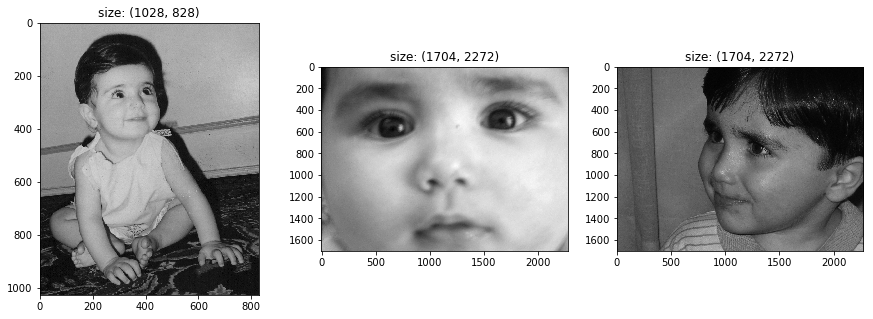

In [9]:
child = loadImage('child.jpg')
face1 = loadImage('face1.jpg')
face2 = loadImage('face2.jpg')
imgs = [child, face1, face2]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, img in enumerate(imgs):
    axs[i].imshow(img)
    axs[i].set_title('size: {}'.format(img.shape))
plt.show()

For box filter and 2-dimensional convolution, we use the functions implemented in section `2-MeanFilters`.

In [10]:
def convolve2d(image, kernel):
    k = kernel.shape[0]
    r = k//2
    # pad the image with zeros
    padded_img = np.pad(image, r, mode='constant', constant_values=0)
    h, w = padded_img.shape
    h = h - k + 1
    w = w - k + 1
    new_image = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            new_image[i, j] = np.sum(padded_img[i:i+k, j:j+k]*kernel)
    return new_image

In [35]:
# single-channel (greyscale) variation of DP box blur
def box_blur(img, kernel_size=(3, 3)):
    # pad new image with 0s
    new_img = np.zeros((img.shape[0] + kernel_size[0] - 1, img.shape[1] + kernel_size[0] - 1), dtype=np.uint8)
    new_img[kernel_size[0]//2:img.shape[0] + kernel_size[0]//2, kernel_size[0]//2:img.shape[1] + kernel_size[0]//2] = img
    # most of the usage works on distance from centre of the kernel
    width, height = new_img.shape
    r = kernel_size[0] // 2
    area = kernel_size[0] * kernel_size[1]
    table = summed_table(new_img)
    for x in range(r + 1, width - r - 1):
        for y in range(r + 1, height - r - 1):
            sum_pixels = np.add(table[x-r-1, y-r-1], 
                            np.subtract(
                                np.subtract(table[x+r, y+r], table[x-r-1, y+r]), 
                                table[x+r, y-r-1]))
            # calculate mean using sum of window
            new_img[x, y] = (sum_pixels//area).astype(np.uint8)
    new_img = new_img[kernel_size[0]//2:img.shape[0] + kernel_size[0]//2, kernel_size[0]//2:img.shape[1] + kernel_size[0]//2]
    return new_img

def summed_table(img):
    width, height = img.shape
    table = np.zeros(img.shape, dtype=np.uint32)
    table[0, 0] = img[0, 0]
    # edge management (akin to padding)
    for x in range(1, width):
        table[x, 0] = np.add(img[x, 0], table[x-1, 0])
    for y in range(1, height):
        table[0, y] = np.add(img[0, y], table[0, y-1])
    for x in range(1, width - 1):
        for y in range(1, height - 1):
            table [x, y] = sum([img[x, y], table[x-1, y], table[x, y-1], (-1)*(table[x-1, y-1])])
    return table

# Unsharp Masking

## Using Box Blur
For a simple setup, we use a kernel of size 3x3:
$$M = {\dfrac {1}{9}}\begin{bmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{bmatrix}$$

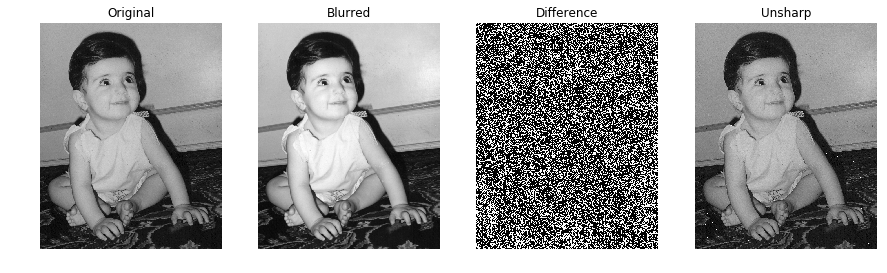

In [163]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
M = 1/9 * (np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]))
axs[0].imshow(child)
axs[0].set_title('Original')
blurred = box_blur(child, kernel_size=(3, 3))
axs[1].imshow(blurred)
axs[1].set_title('Blurred')
diff = np.subtract(child, blurred)
axs[2].imshow(diff)
axs[2].set_title('Difference')
box_unsharp = np.add(child, diff)
axs[3].imshow(box_unsharp)
axs[3].set_title('Unsharp')
for i in range(4):
    axs[i].axis('off')
plt.show()

## Using Weighted Mean Filter
Weighted mean filter is an approximation of a Gaussian blur. The kernel M is defined as:
$$M = \frac{1}{16}\begin{bmatrix}
1 & 2 & 1\\
2 & 4 & 2\\
1 & 2 & 1
\end{bmatrix}$$


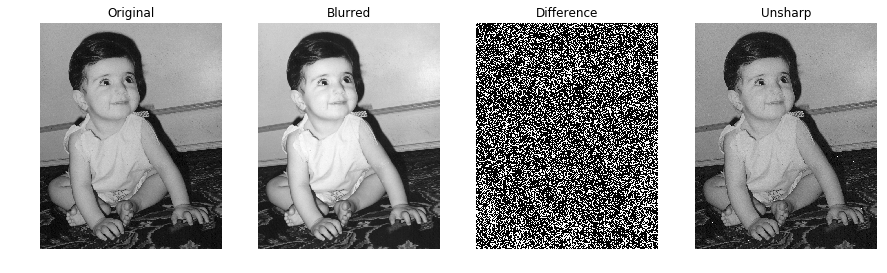

In [162]:
M = 1/16 * (np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]))
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(child)
axs[0].set_title('Original')
blurred = convolve2d(child, M)
axs[1].imshow(blurred)
axs[1].set_title('Blurred')
diff = np.subtract(child, blurred)
axs[2].imshow(diff)
axs[2].set_title('Difference')
weighted_unsharp = np.add(child, diff)
axs[3].imshow(weighted_unsharp)
axs[3].set_title('Unsharp')
for i in range(4):
    axs[i].axis('off')
plt.show()

The white artefacts in the box filter are mostly removed in the weighted average approach.

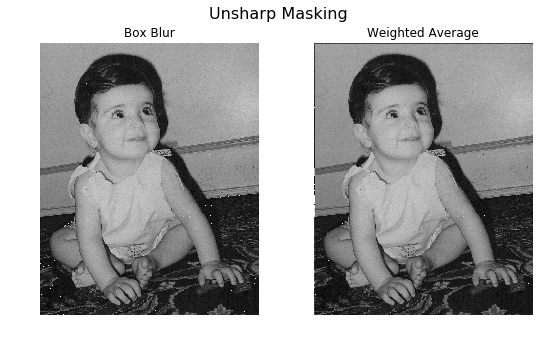

In [164]:
fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.suptitle('Unsharp Masking', fontsize=16)
axs[0].imshow(box_unsharp)
axs[0].set_title('Box Blur')
axs[0].set_axis_off()
axs[1].imshow(weighted_unsharp)
axs[1].set_title('Weighted Average')
axs[1].set_axis_off()
plt.show()

## Other Kernel Sizes (Box Filter)

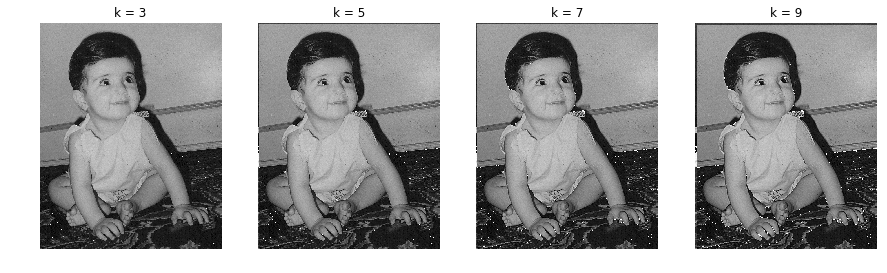

In [360]:
fig, axs = plt.subplots(1,4, figsize=(15, 6))
for i, k in enumerate([3, 5, 7, 9]):
    M = 1/(k**2) * np.ones((k, k))
    blurred = convolve2d(child, M)
    diff = np.subtract(child, blurred)
    unsharp = np.add(child, diff)
    axs[i].imshow(unsharp)
    axs[i].set_title('k = ' + str(k))
    axs[i].axis('off')
plt.show()

The white 'edge' artefacts are more pronounced in the box filter when the kernel size is increased.

## Using Median Filter


In [11]:
def median_filter(img, k=3):
    new_img = np.zeros(img.shape, dtype=np.uint8)
    width, height = img.shape
    r = k // 2
    for x in range(r + 1, width - r - 1):
        for y in range(r + 1, height - r - 1):
            window = img[x-r-1:x+r+1, y-r-1:y+r+1]
            window = window.flatten()
            window.sort()
            new_img[x, y] = window[k*k//2]
    return new_img

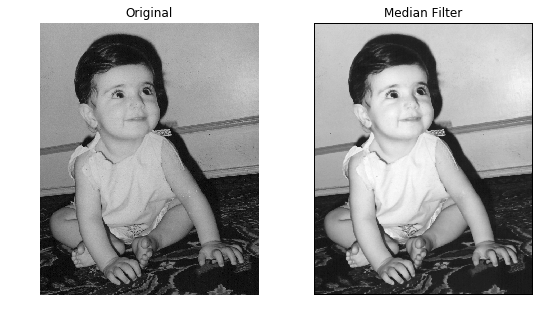

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(child)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(median_filter(child))
axs[1].set_title('Median Filter')
axs[1].axis('off')
plt.show()

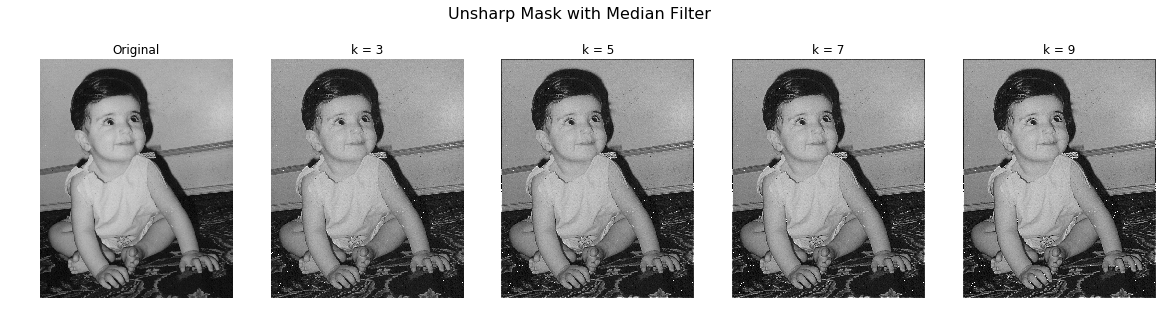

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Unsharp Mask with Median Filter', fontsize=16)
axs[0].imshow(child)
axs[0].set_title('Original')
axs[0].set_axis_off()
for i, k in enumerate([3, 5, 7, 9]):
    median_blurred = median_filter(child, k=k)
    diff = np.subtract(child, median_blurred)
    unsharp = np.add(child, diff)
    axs[i+1].imshow(unsharp)
    axs[i+1].set_title('k = ' + str(k))
    axs[i+1].axis('off')
plt.show()

# Laplacian Filters

In [344]:
M = 1/16 * np.array([[-1, -2 , -1],
                [-2, 12, -2],
                [-1, -2, -1]])
f1_filtered = convolve2d(face1, M)
f1_filtered = (f1_filtered - np.min(f1_filtered)) * 255 / (np.max(f1_filtered) - np.min(f1_filtered))
f1_lap = np.zeros(face1.shape, dtype=np.uint8)
f1_lap = face1 + np.floor(f1_filtered)
f1_lap = f1_lap + np.min(f1_lap)
max_f1_lap = np.max(f1_lap)
if max_f1_lap > 255:
    f1_lap = np.floor(f1_lap / max_f1_lap * 255)

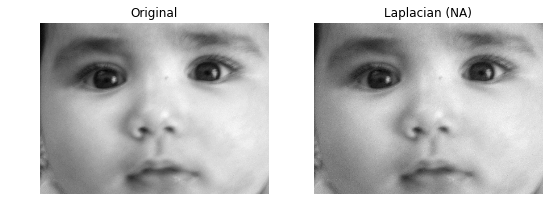

In [464]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(face1)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(f1_lap)
axs[1].set_title('Laplacian (NA)')
axs[1].axis('off')
plt.show()

For `face2.jpg`:

In [350]:
M = 1/16 * np.array([[-1, -2 , -1],
                [-2, 12, -2],
                [-1, -2, -1]])
f2_filtered = convolve2d(face2, M)
f2_filtered = (f2_filtered - np.min(f2_filtered)) * 255 / (np.max(f2_filtered) - np.min(f2_filtered))
f2_lap = np.zeros(face2.shape, dtype=np.uint8)
f2_lap = face2 + np.floor(f2_filtered)
f2_lap = f2_lap + np.min(f2_lap)
f2_max_lap = np.max(f2_lap)
if f2_max_lap > 255:
    f2_lap = np.floor(f2_lap / f2_max_lap * 255)

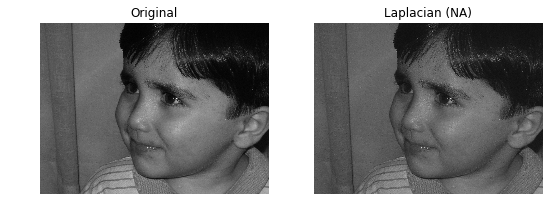

In [460]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(face2)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(f2_lap)
axs[1].set_title('Laplacian (NA)')
axs[1].axis('off')
plt.show()

## Adaptive Unsharp Masking

The eight templates that make up the Laplacian are:

In [473]:
matrices = [np.array([[0, 0, 0],
                        [-2, 2, 0],
                        [0, 0, 0]]),
            np.array([[-1, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]]),
            np.array([[0, -2, 0],
                        [0, 2, 0],
                        [0, 0, 0]]),
            np.array([[0, 0, -1],
                        [0, 1, 0],
                        [0, 0, 0]]),
            np.array([[0, 0, 0], 
                        [0, 2, -2],
                        [0, 0, 0]]),
            np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, -1]]),
            np.array([[0, 0, 0],
                        [0, 2, 0],
                        [0, -2, 0]]),
            np.array([[0, 0, 0],
                        [0, 1, 0],
                        [-1, 0, 0]])
            ]        

In [475]:
def adaptive_laplacian(img, kernels, threshold=200):
    k = kernels[0].shape[0]
    r = k//2
    # pad image reflectively
    padded_img = np.pad(img, r, 'reflect')
    out = np.copy(padded_img)
    for x in range(r, padded_img.shape[0] - r + 1):
        for y in range(r, padded_img.shape[1] - r + 1):
            window = padded_img[x-r:x+r+1, y-r:y+r+1]
            filtered = [convolve2d(window, kernel) for kernel in kernels]
            for f in filtered:
                f = (f - np.min(f)) * 255 / (np.max(f) - np.min(f))
                out[x-r:x+r+1, y-r:y+r+1] += np.where(f > threshold, (1/16 * np.floor(f)).astype(np.uint8), 0)
    out = out[r:img.shape[0] + r, r:img.shape[1] + r]
    return out

In [315]:
f1_alap = adaptive_laplacian(face1, matrices, 20)

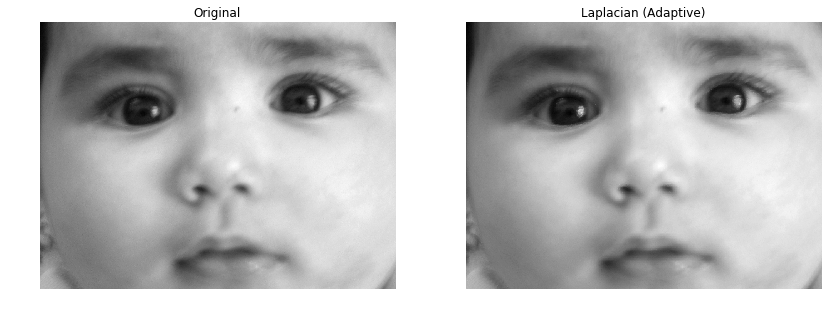

In [467]:
fig, axs = plt.subplots(1,2, figsize=(14, 7))
axs[0].imshow(face1)
axs[0].set_title('Original')
axs[0].set_axis_off()
axs[1].imshow(f1_alap)
axs[1].set_title('Laplacian (Adaptive)')
axs[1].set_axis_off()
plt.show()

Adaptive unsharp masking for `face2.jpg`:

In [480]:
f2_lap = adaptive_laplacian(face2, matrices, 80)

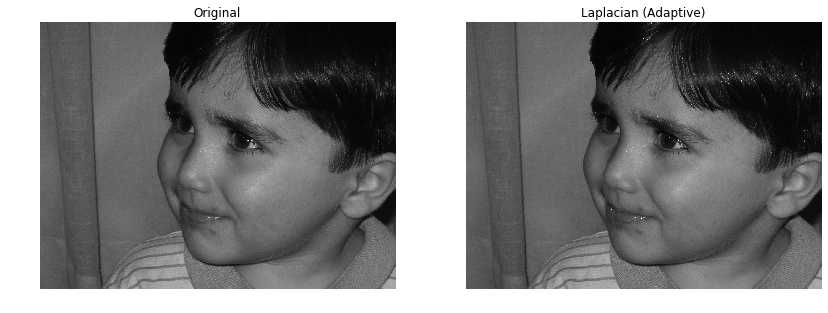

In [482]:
fig, axs = plt.subplots(1,2, figsize=(14, 7))
axs[0].imshow(face2)
axs[0].set_title('Original')
axs[0].set_axis_off()
axs[1].imshow(abs(f2_lap))
axs[1].set_title('Laplacian (Adaptive)')
axs[1].set_axis_off()
plt.show()

We can see the sharpened edges, although some places are saturated due to their local structure.